# AI Agent 101

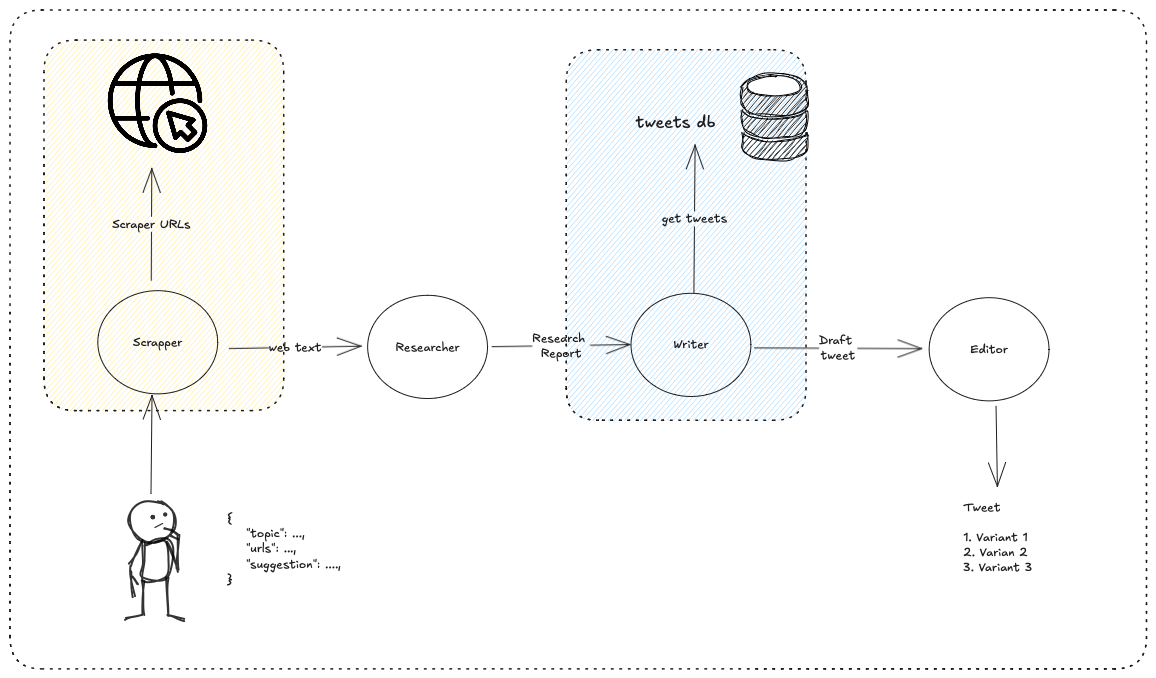

## Config

In [1]:
import os
from enum import Enum
from pathlib import Path
 
class Model(Enum):
    GPT_4o = "gpt-4o-mini"
    LLAMA_3 = "Llama3"

class Config:
    class Path:
        APP_HOME = Path(os.getenv("APP_HOME", Path("__file__").parent.parent))
        DATA_DIR = APP_HOME / "data"
        OUTPUT_DIR = APP_HOME / "output"
        LOGS_DIR = APP_HOME / "logs"
        AGENT_LOGS_DIR = LOGS_DIR / "agents"
 
    MODEL = Model.GPT_4o

## Callbacks

In [2]:
import json
from datetime import UTC, datetime
from pathlib import Path
from typing import Any, Dict, List, Tuple, Union

from langchain.schema import AgentFinish
from langchain.schema.output import LLMResult
from langchain_core.callbacks.base import BaseCallbackHandler

def _current_time() -> str:
    return datetime.now(UTC).isoformat()
 
def _format_log(agent_name: str, event: str, output) -> Dict[str, str]:
    return {
        "agent": agent_name,
        "event": event,
        "timestamp": _current_time(),
        "tool": getattr(output, "tool", "Unknown"),
        "tool_input": getattr(output, "tool_input", "Unknown").strip(),
        "log": getattr(output, "log", "Unknown").strip(),
    }

def step_callback(
    agent_output: Union[str, List[Tuple[Dict, str]], AgentFinish],
    agent_name,
    log_file_path: Path
):
    if isinstance(agent_output, list) and all(
        isinstance(item, tuple) for item in agent_output
    ):
        for action, description in agent_output:
            with log_file_path.open("a", encoding="utf-8") as file:
                file.write(
                    json.dumps(_format_log(agent_name, "agent_step", action)) + "\n"
                )
    elif isinstance(agent_output, AgentFinish):
        with log_file_path.open("a", encoding="utf-8") as file:
            file.write(
                json.dumps(_format_log(agent_name, "agent_finish", agent_output)) + "\n"
            )
            
class LLMCallbackHandler(BaseCallbackHandler):
    def __init__(self, log_path: Path):
        super().__init__()
        self.log_path = log_path
        
    def on_llm_start(
        self, serialized: Dict[str, Any], prompts: List[str], **kwargs: Any
    ) -> Any:
        assert len(prompts) == 1
        data = {"event": "llm_start", "timestamp": _current_time(), "text": prompts[0]}
        with self.log_path.open("a", encoding="utf-8") as file:
            file.write(json.dumps(data) + "\n")
            
    def on_llm_end(self, response: LLMResult, **kwargs: Any) -> Any:
        generation = response.generations[-1][-1].message.content
        data = {"event": "llm_end", "timestamp": _current_time(), "text": generation}
        with self.log_path.open("a", encoding="utf-8") as file:
            file.write(json.dumps(data) + "\n")

## Models

In [3]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

def create_model(model: Model):
    callback = LLMCallbackHandler(Config.Path.LOGS_DIR / "prompts.jsonl")
    if model == Model.LLAMA_3:
        return ChatGroq(
            temperature=0,
            model_name="llama3-70b-8192",
            callbacks=[callback],
        )
    elif model == Model.GPT_4o:
        return ChatOpenAI(
            temperature=0,
            model="gpt-4o",
            callbacks=[callback],
        )

## Tools

In [4]:
from crewai_tools import tool 
 
@tool("save_tweet")
def save_tweet(text: str):
    """Save a tweet text to a markdown file.
    
    Args:
        text: The tweet text to save.
    """
    file_path = Config.Path.OUTPUT_DIR / "tweet.md"
    file_path.parent.mkdir(exist_ok=True, parents=True)
    with file_path.open("w") as file:
        file.write(text)
    return f"Tweet saved to {file_path}"
 
@tool("read_tweets")
def read_tweets():
    """Read example tweets from a markdown file for style reference."""
    tweet_path = Config.Path.DATA_DIR / "tweets.md"
    if tweet_path.exists():
        with tweet_path.open("r") as file:
            return file.read()
    else:
        # Return some default example tweets if file doesn't exist
        return """
        # Example Tweets for Style Reference
                    
        🔥 Just released: GPT-4 Turbo now supports 128K context window! Twice the previous limit, same price. Perfect for long documents and complex tasks. #AI #GPT4 #OpenAI
        
        📊 BERT vs. RoBERTa vs. T5 - Performance comparison on NLU tasks:
        • BERT: 84.6% accuracy
        • RoBERTa: 88.9% accuracy
        • T5: 91.2% accuracy
        Impressive progress in just 2 years! #NLP #MachineLearning
        
        🧠 Llama 2 is now open source! Meta's new LLM outperforms most open models on benchmarks:
        • 70B params
        • Commercial use allowed
        • Improved safety
        Get it now: huggingface.co/meta-llama #LLM #OpenSource #Meta
        """
            
@tool("save_research")
def save_research(text: str):
    """Save research content to a markdown file that will be used by other agents.
    
    Args:
        text: The research content to save.
    """
    file_path = Config.Path.DATA_DIR / "research_output.md"
    file_path.parent.mkdir(exist_ok=True, parents=True)
    with file_path.open("w") as file:
        file.write(text)
    return f"Research saved to {file_path}"

@tool("read_research")
def read_research():
    """Read the research content saved by the researcher."""
    try:
        research_path = Config.Path.DATA_DIR / "research_output.md"
        if research_path.exists():
            with research_path.open("r") as file:
                return file.read()
        else:
            return "No research file found. Please make sure the researcher has completed their work."
    except Exception as e:
        return f"Error reading research: {str(e)}"

## Agents

### Scrapper Agent

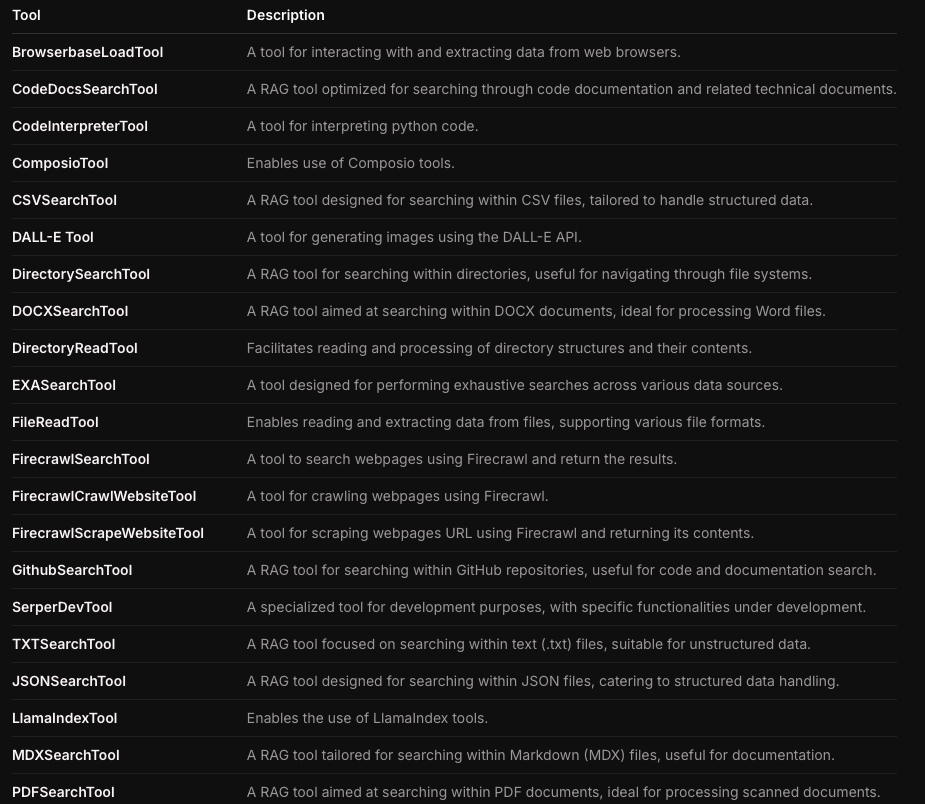

In [5]:
from textwrap import dedent
 
from crewai import Agent
from crewai_tools import ScrapeWebsiteTool

scrape_tool = ScrapeWebsiteTool()
 
def scraper_agent(llm) -> Agent:
    return Agent(
        role="Senior Website Scraper",
        goal="Scrape the content from the provided URLs and return the text data",
        backstory=dedent("""
            You are an experienced software engineer who is a master at scraping various web data (sites, images, videos).
            Your role is to read the content from provided URLs using `scrape_tool` and extract the text.
        """),
        llm=llm,
        tools=[scrape_tool],
        allow_delegation=False,
        step_callback=lambda response: step_callback(
            response, "scrape_agent", Config.Path.AGENT_LOGS_DIR / "scraper.jsonl"
        ),
    )

/Users/danielsyahputra/Library/Caches/pypoetry/virtualenvs/agentic-series-o-ieJOE1-py3.12/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:775: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `CrewAgentExecutor` to V2.
  warn(


### Researcher Agent

In [6]:
def researcher_agent(llm) -> Agent:
    return Agent(
        role="Senior Technical Researcher",
        goal="Extract the key insights and information from the internet on the given topic and provided URLs",
        backstory=dedent("""
            You are a technical researcher with expertise in technologies like
            Artificial Intelligence, Machine Learning, Large Language Models, etc.
            Your role is to summarize the key insights from the provided texts that are related to the given topic.
            IMPORTANT: After completing your research, you MUST save your research using the `save_research` tool
            so that the Writer can access it.
        """),
        llm=llm,
        allow_delegation=False,
        tools=[save_research],
        step_callback=lambda response: step_callback(
            response,
            "researcher_agent",
            Config.Path.AGENT_LOGS_DIR / "researcher.jsonl",
        ),
    )

### Writer Agent

In [7]:
def writer_agent(llm) -> Agent:
    return Agent(
        role="Senior Social Media Writer",
        goal=dedent("""
            Write a tweet post based on the research content.
            First, use the `read_research` tool to access the research content.
            Then use the `read_tweets` tool to read example tweets for style reference.
            Emulate the writing style of the example tweets in your own writing - word choice, formatting, use of emojis, hashtags, etc.
            Finally, save your tweet using the `save_tweet` tool so the editor can access it.
        """),
        backstory=dedent("""
            You have extensive experience in writing engaging content for social media platforms like Twitter, Facebook, Instagram, etc.
            Your main focus is technology - Artificial Intelligence, Machine Learning, Large Language Models, etc.
            You have a track record of writing tweets that engage the audience and drive traffic.
        """),
        llm=llm,
        allow_delegation=False,
        tools=[read_research, read_tweets, save_tweet],
        step_callback=lambda response: step_callback(
            response, "writer_agent", Config.Path.AGENT_LOGS_DIR / "writer.jsonl"
        ),
    )

### Editor Agent

In [8]:
def editor_agent(llm) -> Agent:
    return Agent(
        role="Senior Tweet Editor",
        goal=dedent("""
            Read the original tweet written by the writer using the `read_tweets` tool.
            Write 3 different versions of the tweet based on the original research report.
            Keep the format and style of the original tweet.
            Create a single text that contains all variants (original and different versions) of the tweet.
            Use the `save_tweet` tool and use the `text` parameter to save the text.
        """),
        backstory=dedent("""
            You have experience with social media and understand the importance of engaging content.
            You always write tweets that get a lot of engagement and you are known for your creative writing style.
        """),
        llm=llm,
        allow_delegation=False,
        tools=[read_tweets, save_tweet],
        step_callback=lambda response: step_callback(
            response, "editor_agent", Config.Path.AGENT_LOGS_DIR / "editor.jsonl"
        ),
    )

## Tasks

In [9]:
from textwrap import dedent
from typing import List
 
from crewai import Agent, Task
 
def scrape_content_task(agent: Agent) -> Task:
    return Task(
        description=("Scrape the text from the provided urls {urls}."),
        expected_output="List of the scraped text from the urls.",
        agent=agent,
    )

In [10]:
def research_content_task(agent: Agent) -> Task:
    return Task(
        description=dedent("""
            Use the scraped content to write a research report on the topic {topic}.
        """),
        expected_output="Report with well-structured and accurate content on the topic.",
        agent=agent,
    )

In [11]:
def write_tweet_task(agent: Agent, context: List[Task] = []) -> Task:
    return Task(
        description=dedent("""
            Write the tweet based on the research report and writing style based on the tweets.
            Highlight the main technical details in a bullet list that is engaging and easy to understand.
            Use up to 240 characters. Include relevant hashtags and emojis.
        """),
        expected_output="Text of the tweet.",
        agent=agent,
        context=context,
    )

In [12]:
def edit_task(agent: Agent, context: List[Task] = []) -> Task:
    return Task(
        description=dedent("""
            Create 3 different versions of the tweet based on your critique, the original research report,
            and the suggestion {suggestion}. Save the original tweet and 3 versions of the tweet.
        """),
        expected_output="Saved original tweet and 3 versions of the tweet into a text file.",
        agent=agent,
        context=context,
    )

## Agent Coordination

In [13]:
from crewai import Crew, Process
from dotenv import load_dotenv


load_dotenv()
 
Config.Path.AGENT_LOGS_DIR.mkdir(exist_ok=True, parents=True)
Config.Path.OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
 
llm = create_model(Config.MODEL)

In [14]:
# Definisikan agent
scraper = scraper_agent(llm)
researcher = researcher_agent(llm)
writer = writer_agent(llm)
editor = editor_agent(llm)
 
# Definisikan task
scrape_content = scrape_content_task(scraper)
research_content = research_content_task(researcher)
write_tweet = write_tweet_task(writer, context=[research_content])
edit = edit_task(editor, context=[write_tweet, research_content])

In [15]:
crew = Crew(
    agents=[scraper, researcher, writer, editor],
    tasks=[scrape_content, research_content, write_tweet, edit],
    process=Process.sequential,
    verbose=2,
    memory=False,
    output_log_file=str(Config.Path.LOGS_DIR / "crew.log"),
)

In [16]:
inputs = {
    "topic": "Summary of the key new features of DeepSeek-R1",
    "urls": [
        "https://huggingface.co/deepseek-ai/DeepSeek-R1",
    ],
    "suggestion": "Focus on the performance, how to use the model, and novelty of the model.",
}
 
crew.kickoff(inputs=inputs)
print(crew.usage_metrics)

 [DEBUG]: == Working Agent: Senior Website Scraper
 [INFO]: == Starting Task: Scrape the text from the provided urls ['https://huggingface.co/deepseek-ai/DeepSeek-R1'].
 

deepseek-ai/DeepSeek-R1 · Hugging Face
Hugging Face
					Models
					Datasets
					Spaces
					Posts
					Docs
					Enterprise
Pricing
Log In
Sign Up
deepseek-ai
/
DeepSeek-R1
like
10.5k
Follow
DeepSeek
41.3k
Text Generation
Transformers
Safetensors
deepseek_v3
conversational
custom_code
fp8
arxiv:
2501.12948
License:
mit
			Model card
Files
Files and versions
			Community
			170
			Train
			Deploy
			Use this model
DeepSeek-R1
1. Introduction
2. Model Summary
3. Model Downloads
DeepSeek-R1 Models
DeepSeek-R1-Distill Models
4. Evaluation Results
DeepSeek-R1-Evaluation
Distilled Model Evaluation
5. Chat Website & API Platform
6. How to Run Locally
DeepSeek-R1 Models
DeepSeek-R1-Distill Models
Usage Recommendations
7. License
8. Citation
9. Contact
		DeepSeek-R1
Paper Link👁️
		1. Introduction
We introduce our first-gen